## Regressão Linear

Base de dados: ["Machine Learning with R. Third Edition."](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-r) de Brett Lantz, disponível em: https://github.com/stedy/Machine-Learning-with-R-datasets.

O problema que queremos solucionar é prever os gastos com planos de saúde de acordo com as características do segurado. Poderia ser um problema interessante tanto para os segurados (para saber quais características tornam seu plano mais caro ou barato), quanto para seguradoras (para que mantenha suas contas equilibradas e saiba os segurados que devem ter um preço mais alto/baixo).

Nessa base de dados nossa variável de interesse é a variável `charges` (gastos com planos de saúde) enquanto as variáveis explicativas são:
- `age` (idade),
- `sex` (sexo),
- `bmi` (índice de massa corporal),
- `children` (número de filhos), 
- `smoker` (se é fumante)
- `region` (região)


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pd.set_option("display.float_format", lambda x: "%.2f" % x)

# matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style("ticks")
sns.set_palette("Set2")

In [2]:
# Read_data
df_seguro = pd.read_csv(
    "./data/insurance.csv",
    dtype={
        "age": "int64",
        "sex": "category",
        "bmi": "float64",
        "children": "int64",
        "smoker": "category",
        "region": "category",
        "charges": "float64",
    },
)

# Pré Processamento


Pré-processamento nesse caso inclui:
- encoding binário para variáveis categóricas `sex` e `smoker`
    - Sex: 
        - 0: Female
        - 1: Male
    - Smoker:
        - 0: No
        - 1: Yes
- One Hot Encoding para variável categórica `region`

In [3]:
def pre_processing(df):
    # Como somente temos variáveis nominais, vamos utilizar One Hot Encoder
    # Podemos utilizar o get_dummies do pandas, ou o OneHotEncoder do scikit learn
    # Para variáveis somente com duas classes (sex e smoker), podemos fazer um mapeamento direto
    df_encoded = df.copy()
    df_encoded["male"] = df_encoded["sex"].map({"female": 0, "male": 1})
    df_encoded["male"] = df_encoded["male"].astype(int)
    df_encoded["smoker"] = df_encoded["smoker"].map({"yes": 1, "no": 0})
    df_encoded["smoker"] = df_encoded["smoker"].astype(int)
    df_encoded = df_encoded.drop("sex", axis=1)

    # Para as regiões vamos usar OHE
    regions_col = pd.get_dummies(df_encoded["region"], drop_first=True, dtype=int)
    df_encoded = pd.concat([df_encoded, regions_col], axis=1)
    df_encoded = df_encoded.drop("region", axis=1)

    cols = df_encoded.columns.tolist()
    cols.remove("charges")
    cols.append("charges")

    df_encoded = df_encoded[cols]

    return df_encoded


df_seguro_encoded = pre_processing(df_seguro)

# Estatistica Descritiva

# Dados faltantes

Não há dados faltantes. Caso houvessem dados faltantes nas proximas etapa, depois do split, poderiamos usar técnicas de impoutação de dado ou simplesmente remover as linhas com dados faltantes.

In [4]:
df_seguro.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Distribuição das variáveis numéricas

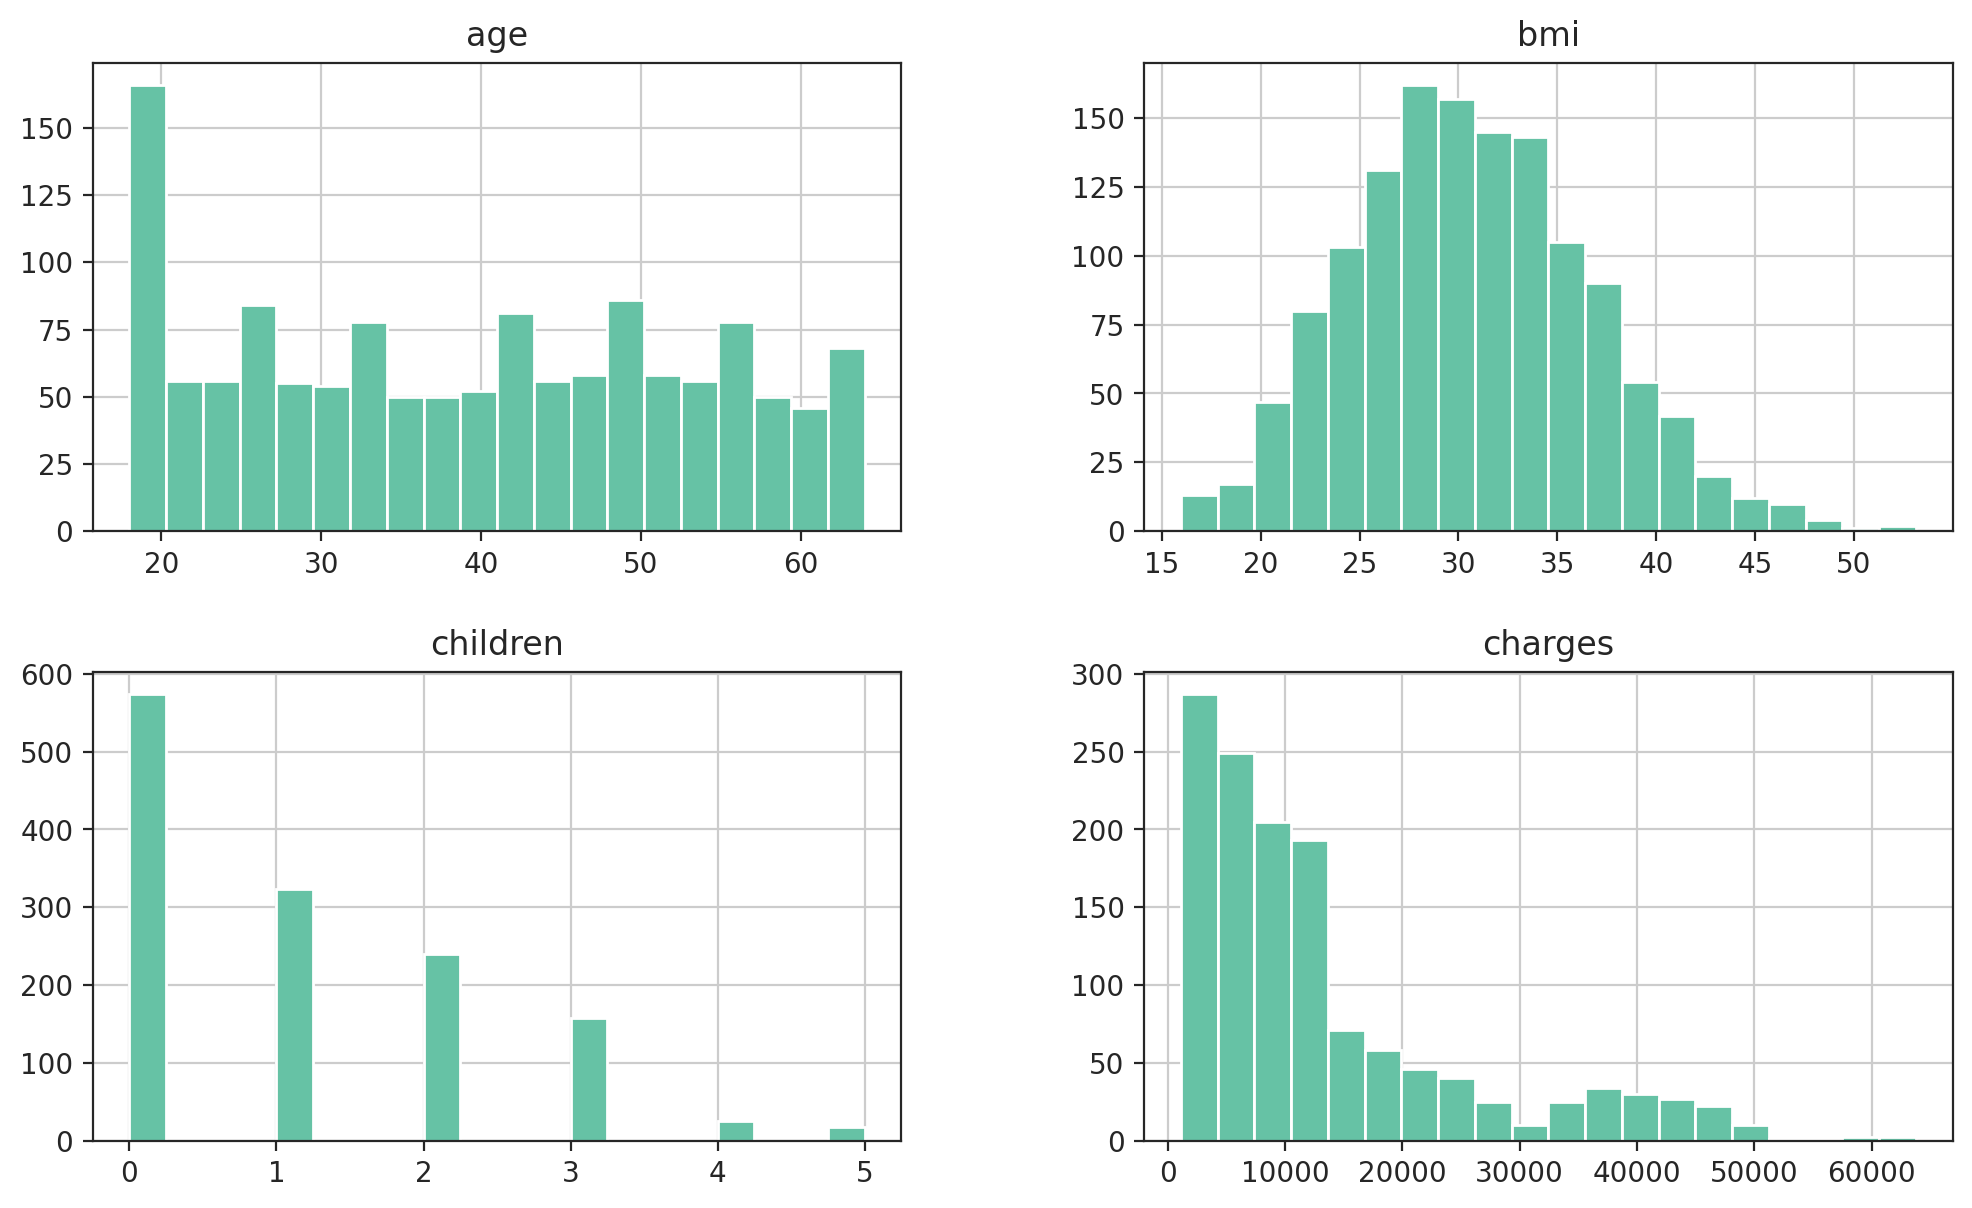

In [5]:
a = df_seguro.hist(figsize=(12, 7), bins=20)

## Relação Preditoras e Target
Analise da variação da variável target, no nosso caso a cobrança do seguro (`charges`), em relação as variáveis preditoras numéricas. Importante para notar se existe multicolinearidade entre as variáveis preditoras.

Fica evidente uma correlação positiva entre idade e as cobranças de planos de saúde (`age x charges`), provavelmente será uma variável de importância no modelo preditivo. Além disso, `smoker` também parece ser uma variável importante, que inclusive parece ter uma interação com o `bmi`.

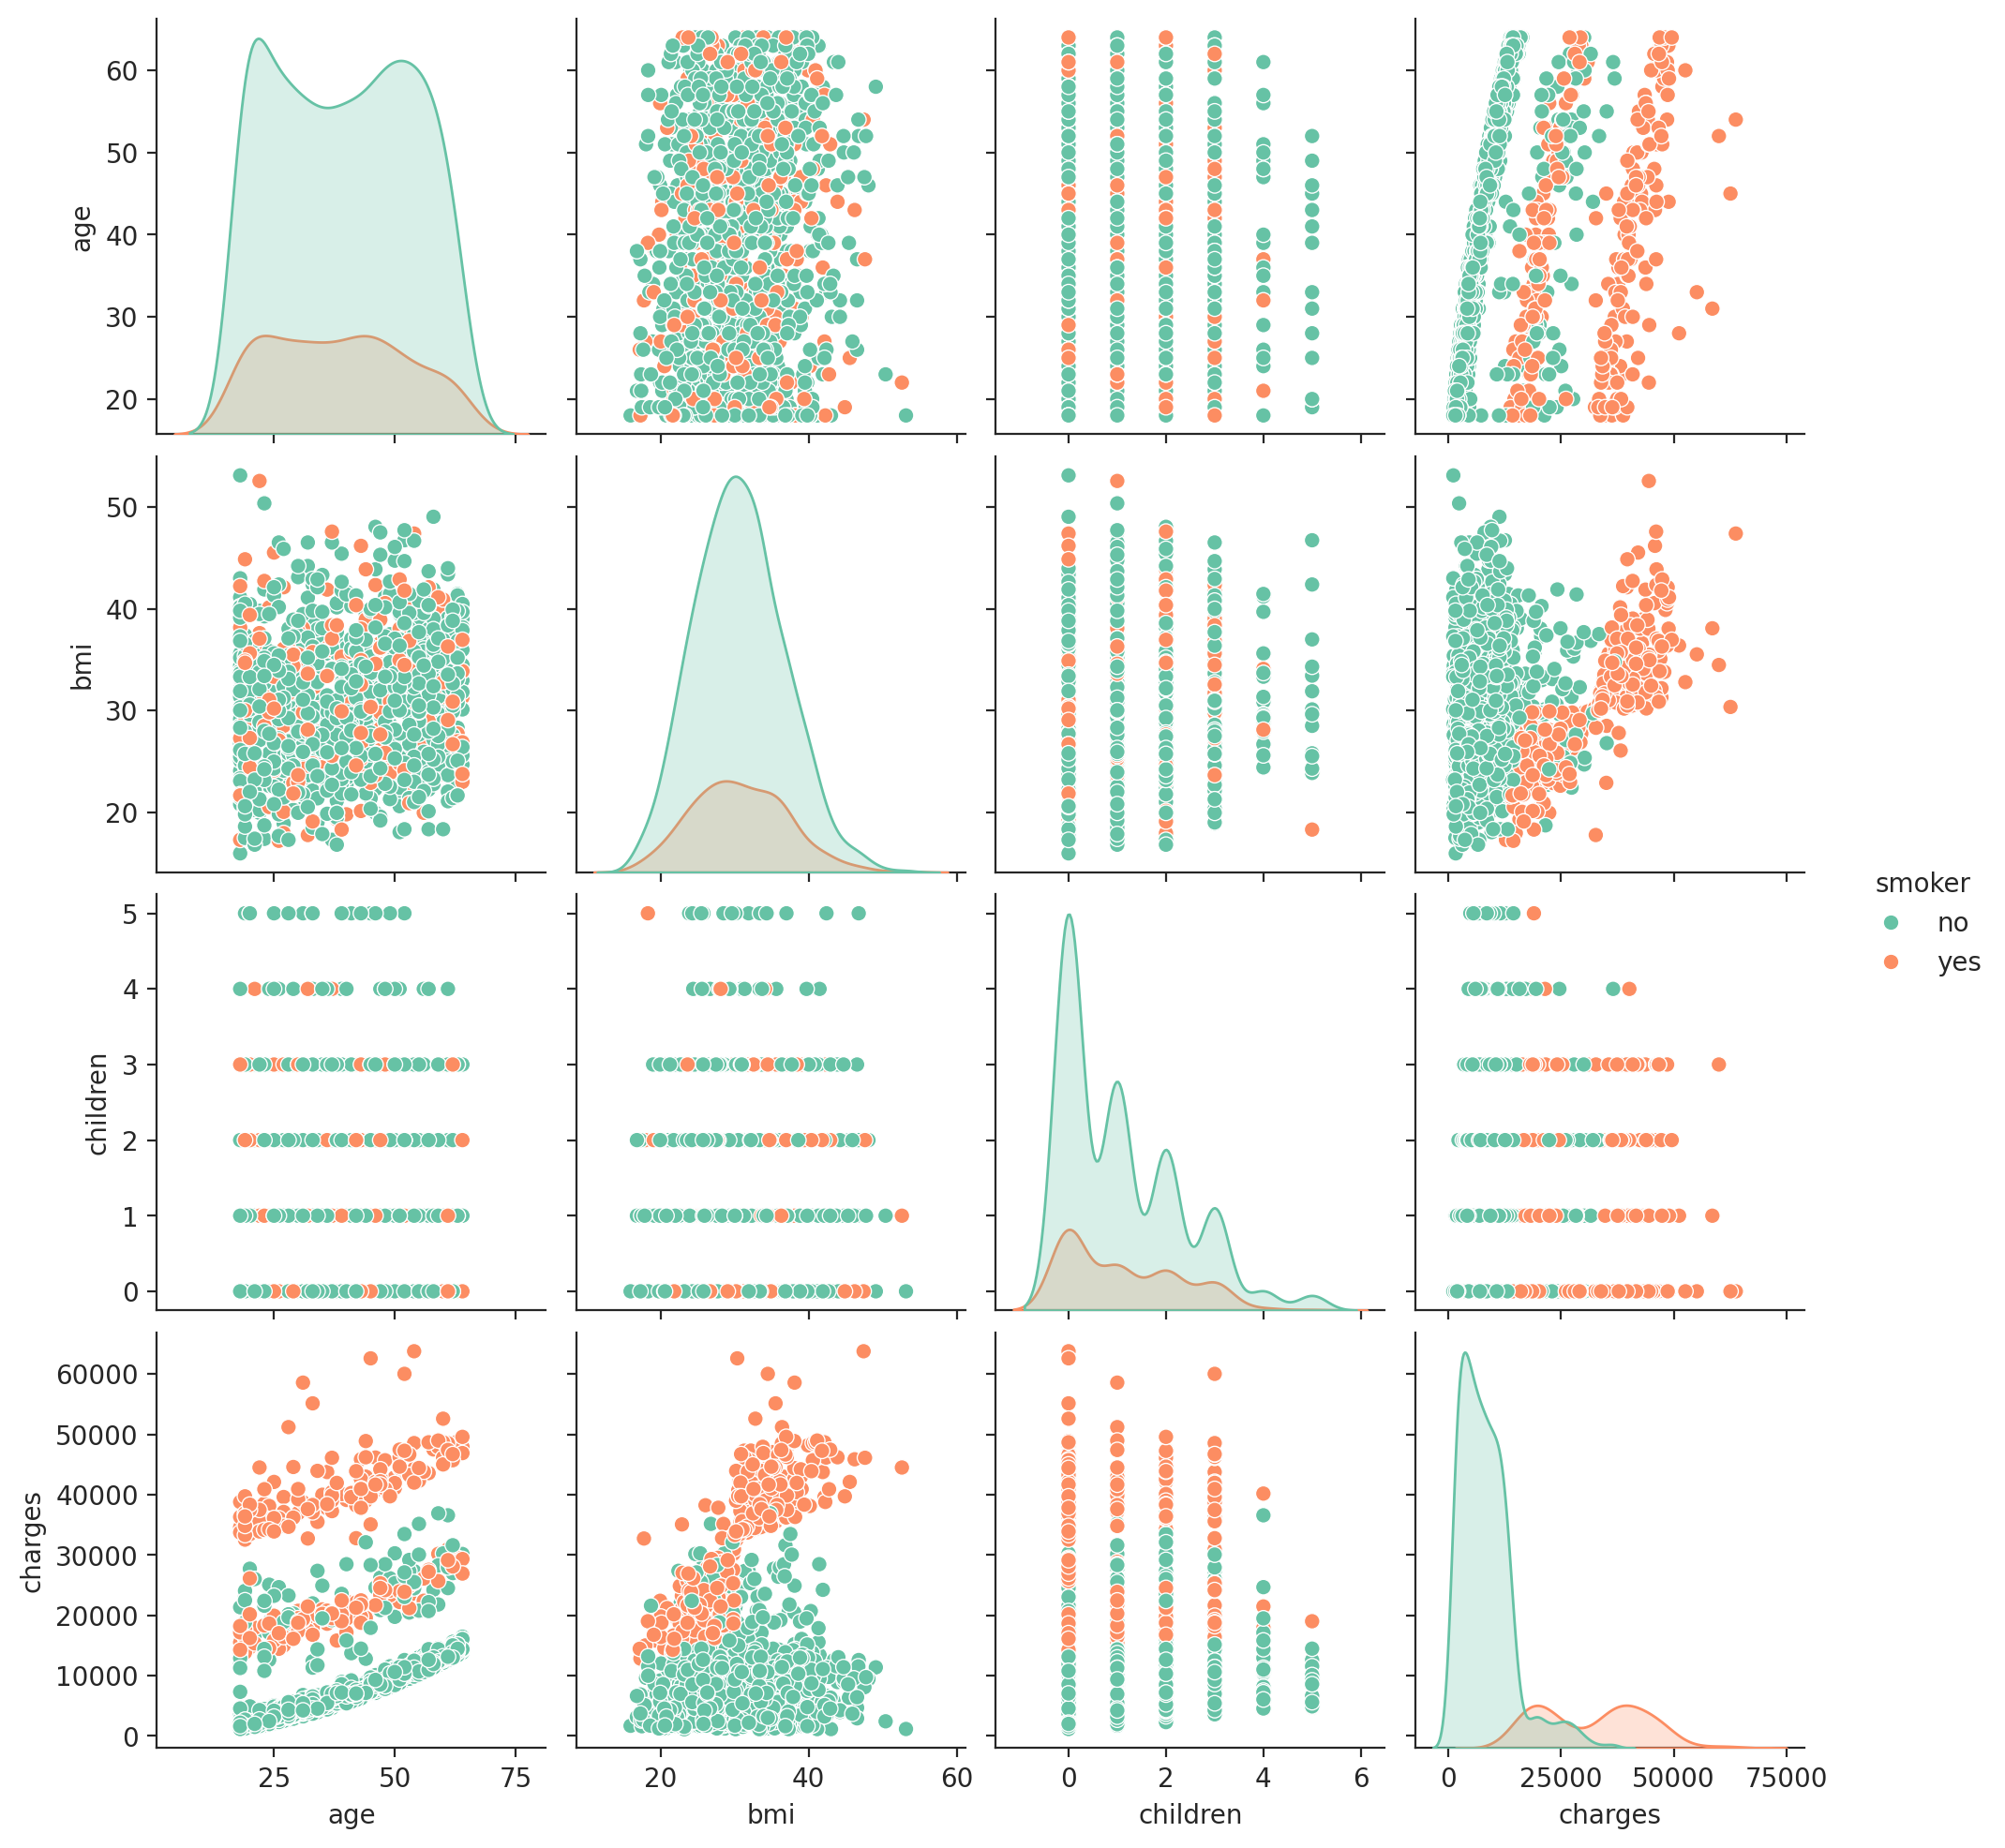

In [6]:
plot = sns.pairplot(data=df_seguro, hue="smoker")
pass

### Matriz de correlação

Assim como nos gráficos de disperão, também podemos usar a matriz de correlação para visualizar se há alguma correlação entre as variáveis da base de dados de seguros.

Nessa matriz vemos uma correlação mais forte entre `charges` e `age`, e, principalmente, entre `charges` e `smoker`.

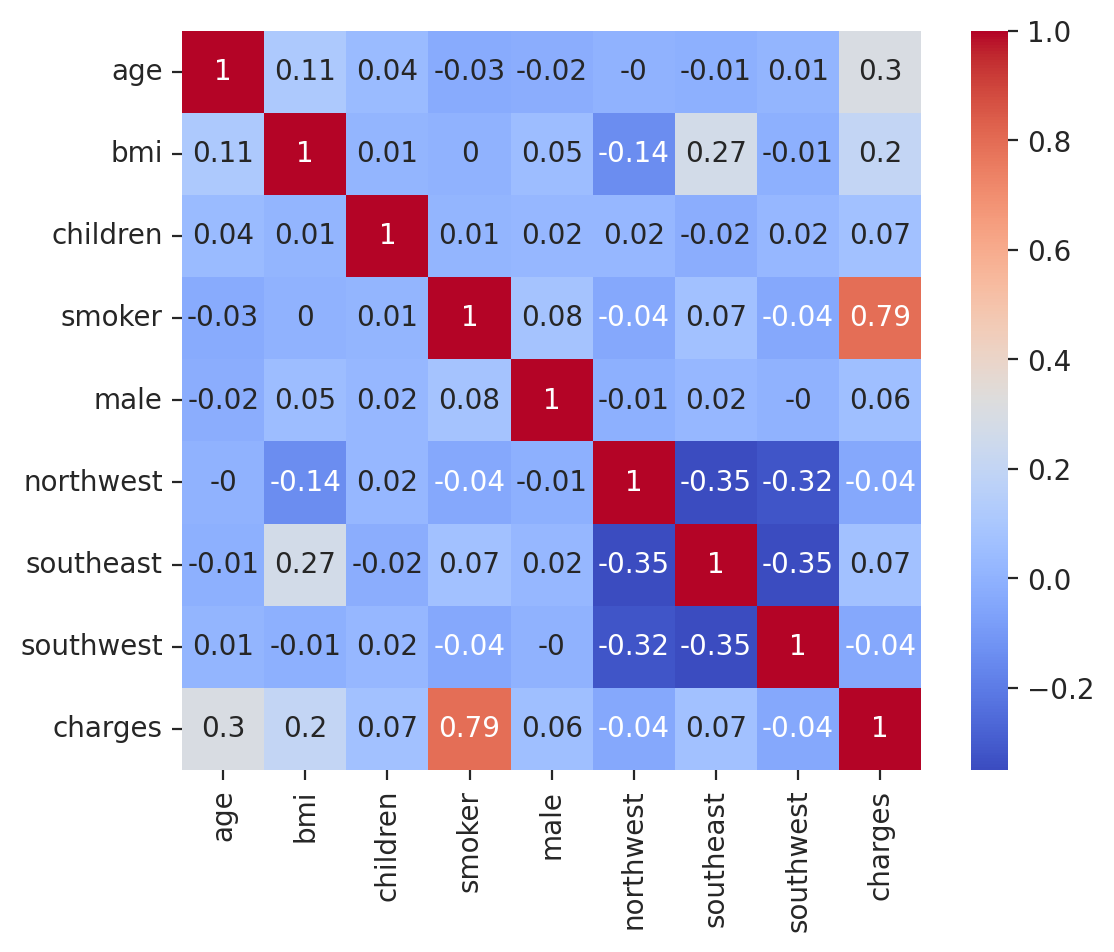

In [7]:
corr = df_seguro_encoded.corr()
corr = corr.round(2)
sns.heatmap(
    corr,
    square=True,
    cmap="coolwarm",
    annot=True,
)
pass

# Separação de bases de treino e teste

Separação de bases de treino e teste, com 80% dos dados para treino e 20% para teste.

In [8]:
def split_data(df, target_col):
    # Separa os dados em treino e teste
    x = df.drop(target_col, axis=1)
    y = df[target_col]

    return train_test_split(
        x,
        y,
        test_size=0.2,
        random_state=53,
    )

In [9]:
x_train, x_test, y_train, y_test = split_data(df_seguro_encoded, target_col="charges")

# Feature Scaling

Feature scaling é uma técnica de pré-processamento que visa colocar as variáveis numéricas na mesma escala. Isso é importante para que variáveis com valores muito altos não dominem o modelo de regressão. Nesse caso vamos usar o MinMaxScaler, que normaliza os dados na escala de 0 a 1.

Algumas obervações sobre o feature scaling:
- O fit deve ser feito somente na base de treino
- O transform deve ser feito nas bases de treino e teste
- Isso porque o scaler deve ser treinado somente com os dados de treino e depois aplicado aos dados de treino e teste
- Caso contrário, o scaler estaria "vazando" informação do teste para o treino

In [10]:
def data_scaling(x_train, x_test):
    scaler_minmax = MinMaxScaler()
    scaler_minmax = scaler_minmax.fit(x_train)  # fit only on training data

    # scale train and test data with the scaler
    x_train[x_train.columns] = scaler_minmax.transform(x_train)
    x_test[x_test.columns] = scaler_minmax.transform(x_test)

    return x_train, x_test


x_train, x_test = data_scaling(x_train, x_test)

# Regressão Linear

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

In [12]:
# Creates regression object and do crossvalidation sets
charges_linreg = LinearRegression()
folds = KFold(n_splits=7, shuffle=True, random_state=53)

### Visualização do Cross Validation

In [13]:
# adapted from: https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression
from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, group, ax, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end

    # Formatting
    n_splits = cv.get_n_splits()
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups):
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(cv, X, y, groups, ax)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Validation", "Train"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

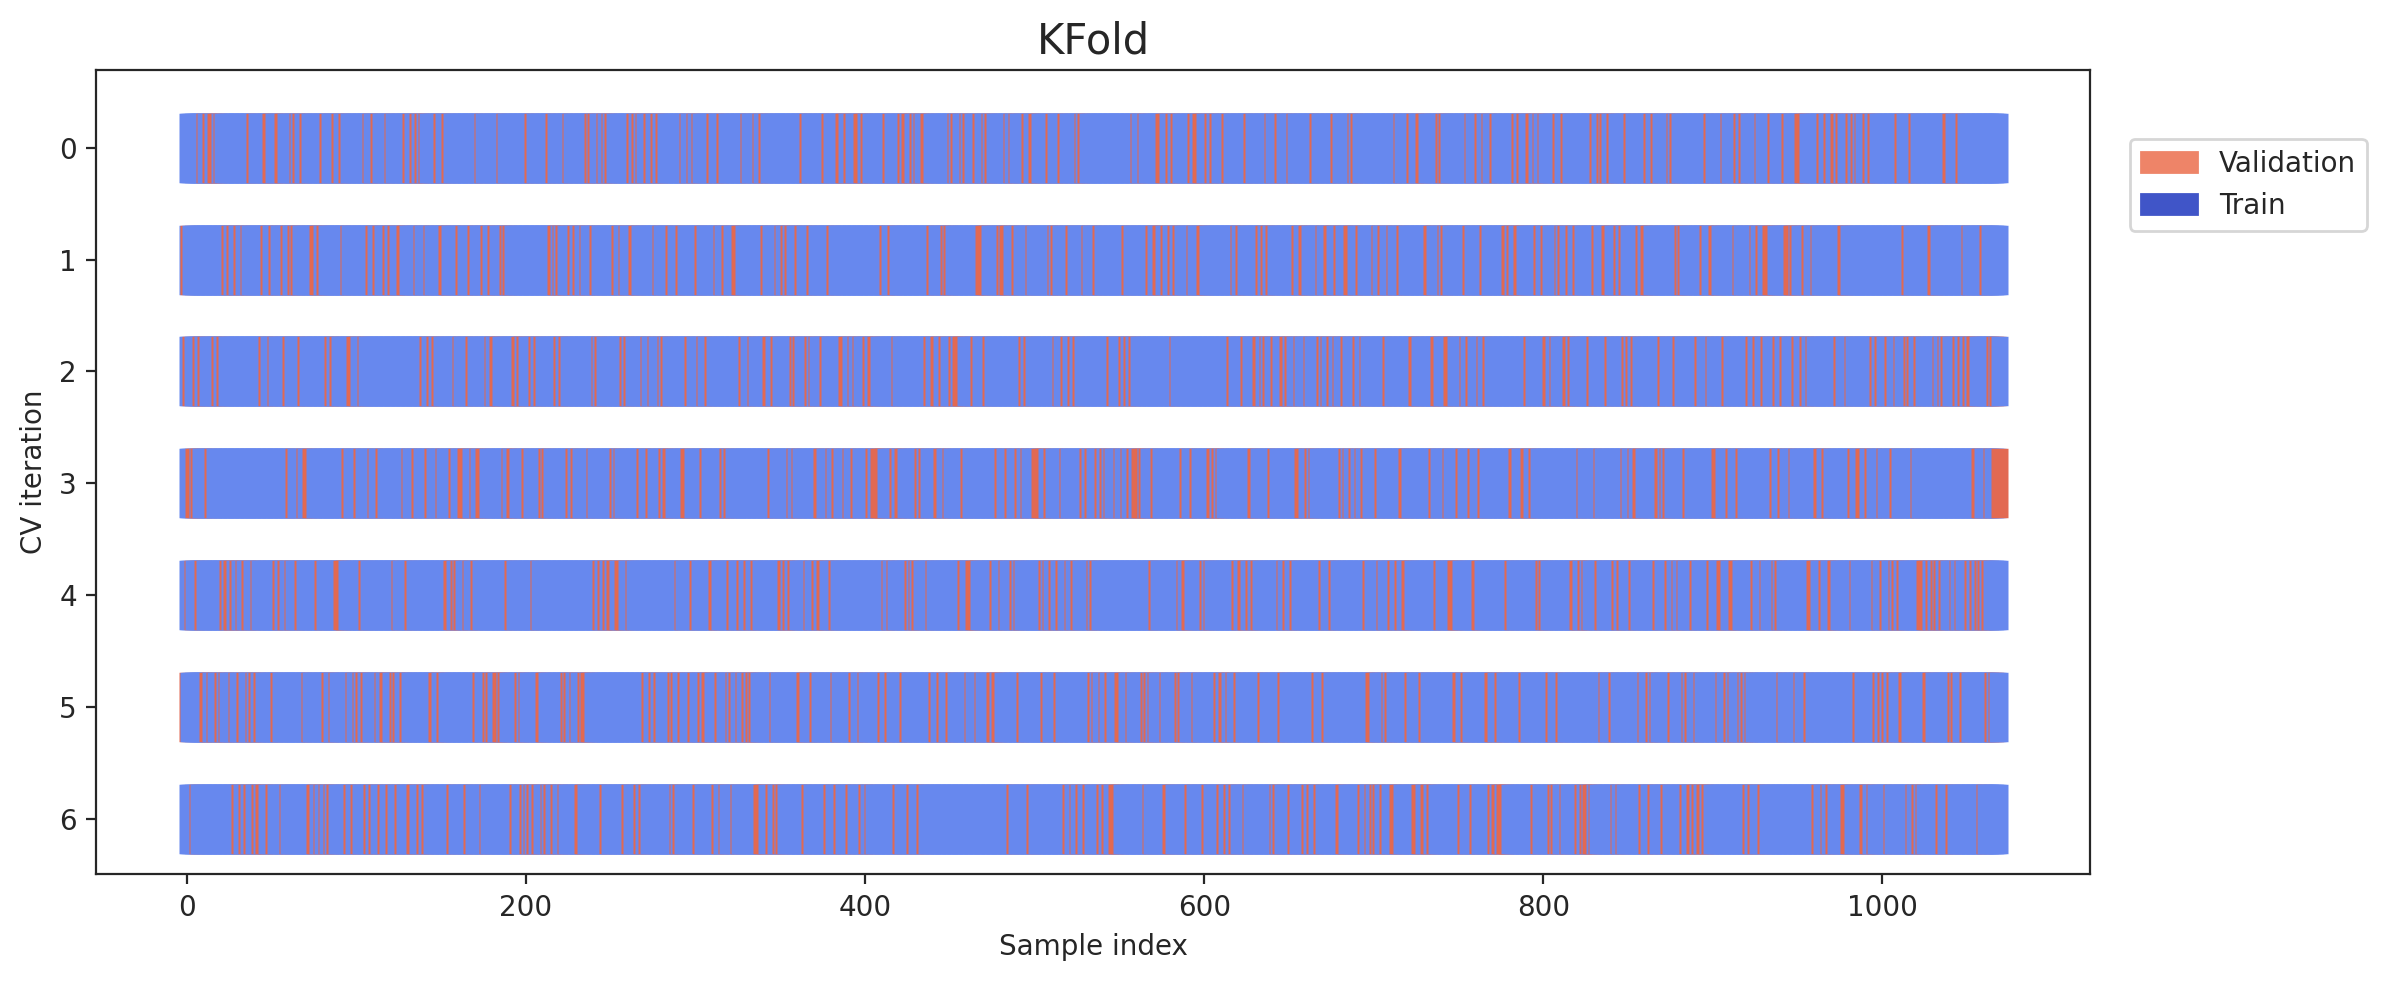

In [14]:
plot_cv(folds, x_train, y_train, None)

### RMSE error

In [15]:
charges_linreg_rmse = cross_validate(
    charges_linreg,
    x_train,
    y_train,
    cv=folds,
    scoring={"neg_root_mean_squared_error": "neg_root_mean_squared_error", "r2": "r2"},
)

charges_linreg_rmse = pd.DataFrame(charges_linreg_rmse)
mean_rmse = charges_linreg_rmse["test_neg_root_mean_squared_error"].mean()
mean_r2 = charges_linreg_rmse["test_r2"].mean()

print("RMSE", -mean_rmse)
print("R2", mean_r2)

RMSE 6124.656834662446
R2 0.7388568802157757


### E se retirarmos as variáveis de região?

In [16]:
col_regions = ["northwest", "southeast", "southwest"]
x_train_noregion = x_train.drop(col_regions, axis=1)

charges_linreg_rmse_noregions = cross_validate(
    charges_linreg,
    x_train_noregion,
    y_train,
    cv=folds,
    scoring={"neg_root_mean_squared_error": "neg_root_mean_squared_error", "r2": "r2"},
)

charges_linreg_rmse_noregions = pd.DataFrame(charges_linreg_rmse_noregions)
mean_rmse = charges_linreg_rmse_noregions["test_neg_root_mean_squared_error"].mean()
mean_r2 = charges_linreg_rmse_noregions["test_r2"].mean()

print("RMSE", -mean_rmse)
print("R2", mean_r2)

RMSE 6144.710208622079
R2 0.7372631219001555


A inclusão das variáveis de região não melhoraram o modelo de maneira significativa. Continuaremos com o modelo sem as variáveis de região a partir de agora.

In [17]:
df_seguro_encoded = df_seguro_encoded.drop(col_regions, axis=1)

# Featuring Engineering

Para melhorarmos a performance do modelo podemos adicionar alguns termos de interações que observamos durante a análise exploratória. Nesse caso usamos um threshold de 30 para categorizar o `bmi`, o que indica sobrepeso. Essa variável é usado para criar termos de interação com `smoker` e `age`.

In [18]:
df_seguro_newfeatures = df_seguro_encoded.copy()

df_seguro_newfeatures["age2"] = df_seguro_newfeatures["age"] ** 2

# thresholding the bmi
df_seguro_newfeatures["bmi30"] = df_seguro_newfeatures["bmi"].apply(
    lambda x: 1 if x > 30 else 0
)

# add interaction terms between smoker and bmi
df_seguro_newfeatures["bmi30*smoker"] = (
    df_seguro_newfeatures["bmi30"] * df_seguro_newfeatures["smoker"]
)

df_seguro_newfeatures["bmi30*age"] = (
    df_seguro_newfeatures["bmi"] * df_seguro_newfeatures["age"]
)

In [19]:
# New data split
(
    x_train_newfeature,
    x_test_newfeature,
    y_train_newfeature,
    y_test_newfeature,
) = split_data(df_seguro_newfeatures, "charges")

In [20]:
charges_linreg_newfeatures = LinearRegression()

charges_linreg_newfeatures_rmse = cross_validate(
    charges_linreg_newfeatures,
    x_train_newfeature,
    y_train_newfeature,
    cv=folds,
    scoring={"neg_root_mean_squared_error": "neg_root_mean_squared_error", "r2": "r2"},
)

charges_linreg_newfeatures_rmse = pd.DataFrame(charges_linreg_newfeatures_rmse)
mean_rmse = charges_linreg_newfeatures_rmse["test_neg_root_mean_squared_error"].mean()
mean_r2 = charges_linreg_newfeatures_rmse["test_r2"].mean()

print("RMSE Regressão Linear com novas features: ", -mean_rmse)
print("R2 Regressão Linear com novas features: ", mean_r2)

RMSE Regressão Linear com novas features:  4459.052923350496
R2 Regressão Linear com novas features:  0.8612783214315812


Melhoramos significativamente o RMSE e o R2 com as novas features, continuaremos com esse modelos como campeão

# Fitando modelo campeão na base de treino

In [21]:
# fitando o modelo escolhido na base inteira
charges_linreg_newfeatures.fit(x_train_newfeature, y_train_newfeature)
pass

In [22]:
charges_linreg_newfeatures.intercept_

64.22316192501421

In [23]:
charges_linreg_newfeatures_coef = pd.DataFrame(
    {
        "feature": x_train_newfeature.columns,
        "coef": charges_linreg_newfeatures.coef_,
    }
)
charges_linreg_newfeatures_coef

,feature,coef
0,age,-26.95
1,bmi,107.18
2,children,683.61
3,smoker,13362.19
4,male,-570.77
5,age2,3.64
6,bmi30,-785.89
7,bmi30*smoker,19858.67
8,bmi30*age,-0.20


In [24]:
precos_preditos = charges_linreg_newfeatures.predict(x_test_newfeature)

In [25]:
residuals = pd.DataFrame(
    {
        "preco_real": y_test_newfeature,
        "preco_preditos": precos_preditos,
        "diff": abs(y_test_newfeature - precos_preditos),
    }
)
residuals["diff"].describe()

count     268.00
mean     2265.55
std      3790.18
min         7.98
25%       948.98
50%      1364.61
75%      1750.38
max     22467.78
Name: diff, dtype: float64

In [26]:
# Importando a métrica
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("Resultados da base de teste:")
print(f"R2: {(r2_score(y_true=y_test_newfeature, y_pred=precos_preditos))}")
print(f"MAE: {(mean_absolute_error(y_true=y_test_newfeature, y_pred=precos_preditos))}")
print(
    f"RMSE: {(mean_squared_error(y_true=y_test_newfeature, y_pred=precos_preditos))**(1/2)}"
)

Resultados da base de teste:
R2: 0.8724421707405609
MAE: 2265.55288438399
RMSE: 4409.597983292361


---

## Fit model using statsmodels

In [29]:
import statsmodels.api as sm
from statsmodels.iolib import summary2

x_train_sm = sm.add_constant(x_train_newfeature)
charges_linreg_sm = sm.OLS(y_train_newfeature, x_train_sm).fit()
charges_linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     753.3
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:21:20   Log-Likelihood:                -10502.
No. Observations:                1070   AIC:                         2.102e+04
Df Residuals:                    1060   BIC:                         2.107e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           64.2232   2278.608      0.028      0.978   -4406.873    4535.319
age            -26.9491     79.432     -0.339      0.734    -182.812     128.914
bmi            107.1795     69.504      1.542      0.123     -29.201     243.560
children       683.6113    119.547      5.718      0.000     449.037     918.186
smoker        1.336e+04    482.098     27.717      0.000    1.24e+04    1.43e+04
male          -570.7743    273.619     -2.086      0.037   -1107.670     -33.878
age2             3.6373      0.847      4.292      0.000       1.975       5.300
bmi30         -785.8862    472.688     -1.663      0.097   -1713.396     141.624
bmi30*smoker  1.986e+04    666.887     29.778      0.000    1.86e+04    2.12e+04
bmi30*age       -0.2009      1.587     -0.127      0.899      -3.315       2.913
==============================================================================
Omnibus:                      703.084   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5431.728
Skew:                           3.140   Prob(JB):                         0.00
Kurtosis:                      12.077   Cond. No.                     4.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
charges_linreg_sm.resid.describe()

count     1070.00
mean        -0.00
std       6085.14
min     -10880.60
25%      -2996.09
50%       -934.47
75%       1740.20
max      24899.38
dtype: float64